## <center>Курсовой проект<a class="anchor" id="course_project"></a><center>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

***

In [1]:
# !pip install feature-engine
# !pip install catboost
# !pip install shap

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
pd.set_option('display.max_columns', 50)

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.impute import KNNImputer
from feature_engine import categorical_encoders as ce
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix

In [5]:
import catboost as cb

***

### Пользовательские функции ###

In [6]:
def dataframes_modification(df_list):
    '''
    Pretty unstructured function to clean data and create new features. df_list - list of dataframes 
    with same columns(so, you have to remove your target column from test df).
    In this case it's train and test parts of single dataframe with dropped target column. 
    Returns copy of dataframes with updated data in list.
    '''
    result = []
    fq_encoder = ce.CountFrequencyCategoricalEncoder(encoding_method='frequency', 
                                                     variables=['Years in current job'])
    oh_encoder = ce.OneHotCategoricalEncoder(top_categories=None, variables=['Home Ownership'])
    ann_imputer = KNNImputer(n_neighbors=3)
    loan_imputer = KNNImputer(n_neighbors=3)
    for i, df in enumerate(df_list):
        df['large_credit_score'] = np.where(df['Credit Score'] > 1000, 1, 0)
        df.loc[df['Credit Score'] > 1000, 'Credit Score'] = df['Credit Score'].median()
        df['has_delinquent'] = np.where(df['Months since last delinquent'].isnull(), 0, 1)
        df['unknown_income'] = np.where(df['Annual Income'].isnull(), 1, 0)
        df.loc[df['Credit Score'].isnull(), 'Credit Score'] = 0
        df['Bankruptcies'] = np.where(df['Bankruptcies'] != 0, 1, 0)
        df.loc[df['Months since last delinquent'].isnull(), 'Months since last delinquent'] = -1
        df.loc[df['Years in current job'].isnull(), 'Years in current job'] = '1 year'
        df['Term'] = np.where(df['Term'] == 'Short Term', 0, 1)
        df['Purpose'] = np.where(df['Purpose'] == 'debt consolidation', 1, 0) 
        df['big_loan_amount'] = np.where(df['Current Loan Amount'] == 99999999.0, 1, 0)
        df.loc[df['Maximum Open Credit'] > 200000000, 'Maximum Open Credit'] = df['Maximum Open Credit'].median()
        if i == 0:
            df = fq_encoder.fit_transform(df)
            df = oh_encoder.fit_transform(df)
            df = pd.DataFrame(ann_imputer.fit_transform(df), columns=df.columns)
        else:
            df = fq_encoder.transform(df)
            df = oh_encoder.transform(df)
            df = pd.DataFrame(ann_imputer.transform(df), columns=df.columns)
        df.loc[(df['Current Loan Amount'] == 99999999.0), 'Current Loan Amount'] = np.nan
        
        if i == 0:
            df = pd.DataFrame(loan_imputer.fit_transform(df), columns=df.columns)
        else:
            df = pd.DataFrame(loan_imputer.transform(df), columns=df.columns)
            
        df['Years of Credit History'] = df['Years of Credit History'] // 10 * 10
        df['long_term_with_large_amount'] = np.where((df['Term'] == 1) & 
                                                     (df['Current Loan Amount'] > 150000), 1, 0)
        df['low_income_low loan'] = np.where((df['Annual Income'] < 100000) 
                                             | (df['Current Loan Amount'] < 300000), 1, 0)
        gp = df_train.groupby(['Credit Score'])['Maximum Open Credit'].mean()
        df['mean_moc_per_cs'] = df['Credit Score'].map(gp.to_dict())
        gp = df.groupby(['Tax Liens'])['Annual Income'].mean()
        result.append(df)
    return result

In [7]:
def pdf_plot(col_name, df):
    '''
    plot probability density function. df - dataframe, col_name - feature to plot
    '''
    target_mean = round(df[col_name].mean(), 2)
    target_median = df[col_name].median()
    plt.figure(figsize = (12, 5))
    sns.distplot(df[col_name])
    y = np.linspace(0, 0.0000005, 100)
    plt.plot([target_mean] * 100, y, label='mean', linestyle=':', linewidth=4)
    plt.plot([target_median] * 100, y, label='median', linestyle='--', linewidth=4)
    plt.title(col_name)
    plt.legend()
    plt.show()
    

In [8]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [9]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [10]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred, model, X_test):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred, digits=3))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred, digits=3))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))
    plot_confusion_matrix(model, X_test, y_test_true, cmap=plt.cm.Blues, normalize='all')

Константы

In [11]:
SEED = 42
TEST_DATA = './data/course_project_test.csv'
TRAIN_DATA = './data/course_project_train.csv'
TARGET_NAME = 'Credit Default'

Подгружаем датасеты

In [12]:
df_train = pd.read_csv(TRAIN_DATA)
df_test = pd.read_csv(TEST_DATA)

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

## Exploratory data analisis

Оценим датасеты

In [13]:
df_train.head(3)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0


In [14]:
df_test.head(3)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0


Первично посмотрим датасет в разрезе целевой переменной

In [15]:
df_train[df_train['Credit Default'] == 0].describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,4.359000e+03,5387.000000,5387.000000,5387.000000,5.387000e+03,5387.000000,2436.000000,5377.000000,5.387000e+03,5.387000e+03,5387.000000,4359.000000,5387.0
mean,1.418047e+06,0.025988,11.042138,18.408168,1.088422e+06,0.163727,34.656814,0.116794,1.640219e+07,2.937194e+05,18176.425469,723.577885,0.0
std,8.845096e+05,0.256502,4.871796,6.959349,1.890526e+07,0.480127,21.516233,0.344130,3.669223e+07,3.359989e+05,11917.013432,25.412545,0.0
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,590.000000,0.0
25%,8.663525e+05,0.000000,8.000000,13.700000,2.895860e+05,0.000000,17.000000,0.000000,1.798060e+05,1.145035e+05,9894.500000,713.000000,0.0
50%,1.225747e+06,0.000000,10.000000,17.100000,4.937460e+05,0.000000,32.000000,0.000000,3.145340e+05,2.092850e+05,15939.000000,732.000000,0.0
75%,1.709572e+06,0.000000,14.000000,22.000000,8.233610e+05,0.000000,50.000000,0.000000,5.510780e+05,3.629095e+05,23717.500000,742.000000,0.0
max,1.014934e+07,7.000000,43.000000,51.900000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,751.000000,0.0


In [16]:
df_train[df_train['Credit Default'] == 1].describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,1.584000e+03,2113.000000,2113.000000,2113.000000,2.113000e+03,2113.000000,983.000000,2109.000000,2113.000000,2.113000e+03,2113.000000,1584.000000,2113.0
mean,1.224243e+06,0.040700,11.357312,18.086228,5.798982e+05,0.185991,34.781282,0.118065,326651.044013,2.799256e+05,18666.352106,2327.548611,1.0
std,7.077733e+05,0.306572,4.996364,7.244804,5.517541e+05,0.542644,22.121493,0.354961,186027.080635,2.659432e+05,11947.197046,2787.985441,0.0
min,1.940280e+05,0.000000,2.000000,4.500000,0.000000e+00,0.000000,0.000000,0.000000,21472.000000,0.000000e+00,0.000000,585.000000,1.0
25%,7.726730e+05,0.000000,8.000000,13.100000,2.562560e+05,0.000000,15.000000,0.000000,181610.000000,1.124610e+05,10534.000000,704.000000,1.0
50%,1.055916e+06,0.000000,11.000000,16.700000,4.420900e+05,0.000000,33.000000,0.000000,290576.000000,2.101020e+05,16390.000000,730.500000,1.0
75%,1.493894e+06,0.000000,14.000000,21.500000,7.279580e+05,0.000000,52.000000,0.000000,444708.000000,3.536470e+05,24057.000000,6162.500000,1.0
max,8.710740e+06,5.000000,42.000000,57.700000,6.639358e+06,5.000000,86.000000,4.000000,788634.000000,3.944514e+06,104036.000000,7510.000000,1.0


**Какие выводы можно сделать:**
- Annual Income. Среднее значение, квантильные и максимальные у дефолтных клиентов ниже, что логично. Чем меньше у человека доход, тем с большей вероятностью он не вернет кредит. Есть корреляция с целевой переменной, можно использовать для создания новых признаков
- Tax Liens, Maximum Open Credit, Number of Credit Problems, Bancruptcies, Monthly Debt - несмотря на многообещающее значение этих столбцов показывают мало связи с дефолтными клиентами, по крайней мере по значениям основных статистик. Возможно влияние выбросов.
- Credit Score - Явная связь с целевой переменной, возможно за счет выбросов. Даже если это выбросы, можно их преобразовать в дополнительный бинарный признак
- Current Loan Amount - Можно предположить тенденцию к тому, что люди, которые берут кредиты на меньшие суммы возращают их реже, чем те, которые берут бОльшие суммы
- Current Credit Balance - особой зависимости не видно

Итого:
Обратить внимание на Annual Income, Credit Score, Current Loan Amount

In [17]:
df_train.shape

(7500, 17)

In [18]:
df_test.shape

(2500, 16)

In [19]:
set(df_train.columns) ^ set(df_test.columns)

{'Credit Default'}

Пропусков в целевой переменной не видим

In [20]:
df_train['Credit Default'].isnull().any()

False

Посмотрим, есть ли пропуски в данных

In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [22]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

Как видим, пропусков достаточно много. Оценим столбцы, с которыми надо будет работать

In [23]:
nan_col = df_train.columns[df_train.isna().any()].tolist()
nan_col

['Annual Income',
 'Years in current job',
 'Months since last delinquent',
 'Bankruptcies',
 'Credit Score']

In [24]:
test_nan_col = df_test.columns[df_test.isna().any()].tolist()
set(test_nan_col) ^ set(nan_col)

set()

Пропуски в тренировочном и тестовым датасетах присутствуют в одинаковых столбцах, соответственно обрабатываться будут одинаково.

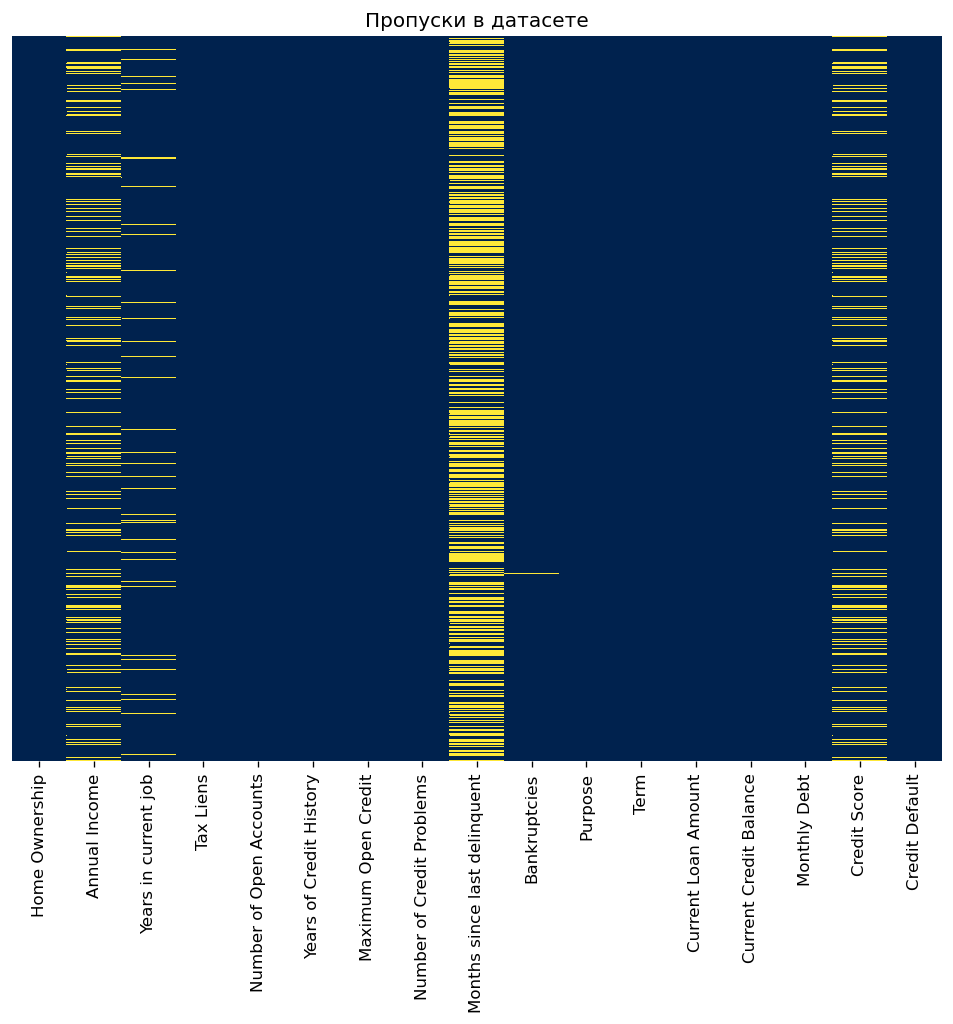

In [25]:
plt.figure(figsize=(10, 8), dpi=120)
plt.title('Пропуски в датасете')
sns.heatmap(df_train.isnull(), cbar=False, yticklabels=False, cmap = 'cividis')
plt.show()

In [26]:
for col in nan_col:
    print(col, 'Количество уникальных значений:', df_train[col].nunique())
    print(df_train[col].value_counts(normalize=True, dropna=False), '\n\n')

Annual Income Количество уникальных значений: 5478
NaN          0.207600
1161660.0    0.000533
1058376.0    0.000533
1043651.0    0.000533
1338113.0    0.000533
               ...   
1141254.0    0.000133
7907382.0    0.000133
1534478.0    0.000133
972040.0     0.000133
585751.0     0.000133
Name: Annual Income, Length: 5479, dtype: float64 


Years in current job Количество уникальных значений: 11
10+ years    0.310933
2 years      0.094000
3 years      0.082667
< 1 year     0.075067
5 years      0.068800
1 year       0.067200
4 years      0.062533
6 years      0.056800
7 years      0.052800
NaN          0.049467
8 years      0.045200
9 years      0.034533
Name: Years in current job, dtype: float64 


Months since last delinquent Количество уникальных значений: 89
NaN      0.544133
14.0     0.010133
29.0     0.009467
8.0      0.009067
33.0     0.009067
           ...   
84.0     0.000133
92.0     0.000133
86.0     0.000133
118.0    0.000133
91.0     0.000133
Name: Months since last de

Какие выводы можно сделать:
- **Annual income** - числовые непрерывные данные. Пропусков - 20%. Признак может быть достаточно значимым, так как доход клиента прямо влияет на его способность погасить кредит. Добавим признак неизвестного дохода и заменим пропуски KNN
- **Years in current job** - категориальный признак. Количество пропусков незначительно, можно заполнить медианой, модой. Кроме того, большое количество категорий составляют малый процент от признака, поэтому, возможно, имеет смысл объединить в одну категорию. Кроме того, это тип object, соответственно нужно применить one_hot_encoding либо частотное кодирование
- **Months since last delinquent** - категориальный признак. Количество пропусков 54%, но скорее всего, отсутствующие значения - это знак того, что клиент не имел просрочек по кредитам. Можно приравнять -1. Кроме того, возможно имеет смысл создать новый бинарный признак для клиентов без просрочек. Общее количество категорий очень велико, возможно имеет смысл объединить категории.
- **Bankruptcies** - Также категориальный признак. Количество пропусков невелико. Кроме того, около 88% приходится на 0, 10% на 1. Имеет смысл преобразовать в бинарный признак
- **Credit Score** - Категориальный признак с большим количеством категорий(268). Количество пропусков велико - 20%. Но, исходя из логики признака, это может означать, что клиент берет кредит первый раз, соответственно, никаких данных по нему в банковской истории нет. Заменим NaN значения на 0

In [27]:
df_train[nan_col].describe()

,Annual Income,Months since last delinquent,Bankruptcies,Credit Score
count,5.943000e+03,3419.000000,7486.000000,5943.000000
mean,1.366392e+06,34.692600,0.117152,1151.087498
std,8.453392e+05,21.688806,0.347192,1604.451418
min,1.645970e+05,0.000000,0.000000,585.000000
25%,8.443410e+05,16.000000,0.000000,711.000000
50%,1.168386e+06,32.000000,0.000000,731.000000
75%,1.640137e+06,50.000000,0.000000,743.000000
max,1.014934e+07,118.000000,4.000000,7510.000000


**Визуализируем столбцы с пропусками**

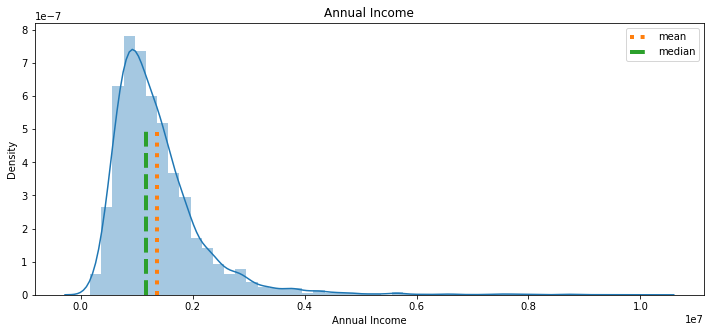

In [28]:
pdf_plot('Annual Income', df_train)

Распределение дохода выглядит нормально, с положительным коэффициентом ассиметрии. Значительного количества выбросов по графику не видно

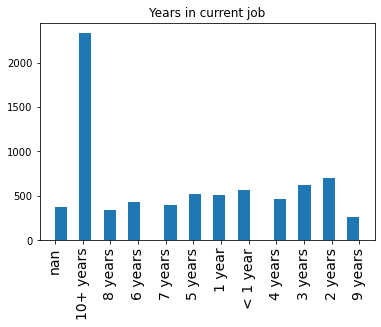

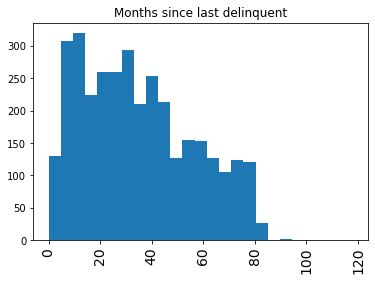

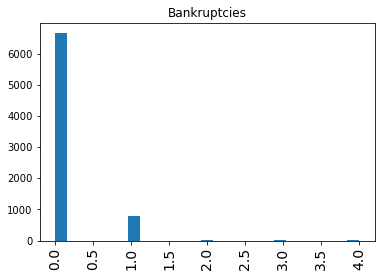

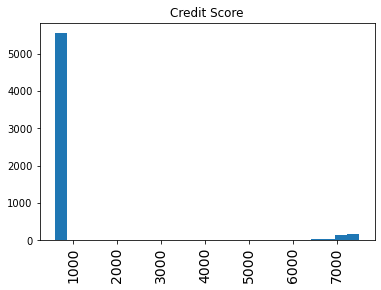

In [29]:
for i in nan_col[1:]:
    plt.figure(figsize=(6, 4))
    plt.hist(df_train[i], bins=25)
    plt.xticks(fontsize=14, rotation=90)
    plt.title(i)
    plt.show()

In [30]:
df_train['Credit Score'].value_counts()

740.0     169
747.0     168
748.0     157
745.0     152
741.0     151
         ... 
602.0       1
616.0       1
585.0       1
620.0       1
7010.0      1
Name: Credit Score, Length: 268, dtype: int64

In [31]:
df_train[df_train['Months since last delinquent'] > 81]['Months since last delinquent'].value_counts()

82.0     4
83.0     3
92.0     1
91.0     1
84.0     1
118.0    1
86.0     1
Name: Months since last delinquent, dtype: int64

In [32]:
df_train[df_train['Bankruptcies'] > 0]['Bankruptcies'].value_counts()

1.0    786
2.0     31
3.0      7
4.0      2
Name: Bankruptcies, dtype: int64

In [33]:
df_train['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [34]:
df_train[df_train['Credit Score'] > 1000]['Credit Score'].value_counts()

7400.0    15
7300.0    13
7330.0    13
7170.0    12
7370.0    12
          ..
6830.0     1
6910.0     1
6450.0     1
6610.0     1
6170.0     1
Name: Credit Score, Length: 110, dtype: int64

**Выводы:**
- Months since last delinquent значения после 80 можно убрать
- Bankruptcies - так как из 5х значений признака 3 встречаются очень редко, имеет смысл преобразовать признак в бинарный
- Присутствуют явные выбросы в Credit Score

Создадим бинарные признаки - была просрочка или нет; известный доход или нет

### Преобразование объектных столбцов

In [35]:
obj_col = df_train.columns[df_train.dtypes == 'object'].tolist()
for col in obj_col:
    print(df_train[col].value_counts(normalize=True), end='\n\n')

Home Mortgage    0.484933
Rent             0.427200
Own Home         0.086267
Have Mortgage    0.001600
Name: Home Ownership, dtype: float64

10+ years    0.327115
2 years      0.098892
3 years      0.086969
< 1 year     0.078973
5 years      0.072380
1 year       0.070697
4 years      0.065788
6 years      0.059756
7 years      0.055548
8 years      0.047552
9 years      0.036330
Name: Years in current job, dtype: float64

debt consolidation      0.792533
other                   0.088667
home improvements       0.054933
business loan           0.017200
buy a car               0.012800
medical bills           0.009467
major purchase          0.005333
take a trip             0.004933
buy house               0.004533
small business          0.003467
wedding                 0.002000
moving                  0.001467
educational expenses    0.001333
vacation                0.001067
renewable energy        0.000267
Name: Purpose, dtype: float64

Short Term    0.7408
Long Term     0.2592
Name

**Выводы:**

- Признак **Term** принимает 2 значения, поэтому преобразовываем его в бинарный
- Признак **Purpose** сильно несбалансирован, есть категория debt consolidation содержащая 80% всей выборки, еще около 10% в other. Имеет смысл преобразовать признак в бинарный
- С помощью частоного кодирования и one hot encoding'a преобразуем признаки **Years in current job** и **Home Ownership** соответственно
- Заполняем **Annual Income** с помощью KNNImputer

### Работа с выбросами

Разделим столбцы на числовые и категориальные по количеству уникальных значений

In [36]:
num_unq = list(map(lambda col: df_train[col].nunique(), df_train.columns.tolist()))
d = dict(zip(df_train.columns.tolist(), num_unq))
sorted(d.items(), key=lambda x: x[1])

[('Term', 2),
 ('Credit Default', 2),
 ('Home Ownership', 4),
 ('Bankruptcies', 5),
 ('Tax Liens', 8),
 ('Number of Credit Problems', 8),
 ('Years in current job', 11),
 ('Purpose', 15),
 ('Number of Open Accounts', 39),
 ('Months since last delinquent', 89),
 ('Credit Score', 268),
 ('Years of Credit History', 408),
 ('Current Loan Amount', 5386),
 ('Annual Income', 5478),
 ('Current Credit Balance', 6592),
 ('Monthly Debt', 6716),
 ('Maximum Open Credit', 6963)]

Признак **Purpose** сильно несбалансирован, есть категория debt consolidation содержащая 80% всей выборки, еще около 10% в other. Имеет смысл преобразовать признак в бинарный

С помощью частоного кодирования и one hot encoding'a преобразуем признаки **Years in current job** и **Home Ownership** соответственно

Заполняем Annual Income с помощбю KNNImputer

In [37]:
num_col = [key for key, item  in d.items() if item > 500]
cat_col = list(set(df_train.columns) - set(num_col))

    Разделим столбцы на числовые и категориальные по количеству уникальных значений

Посмотрим на возможные выбросы в числовых столбцах

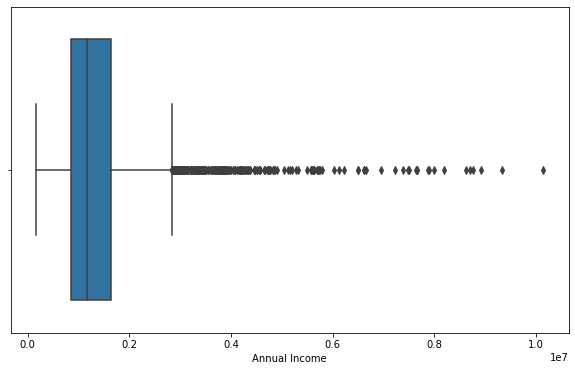

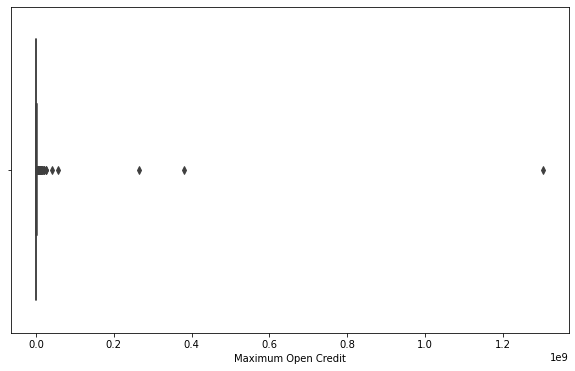

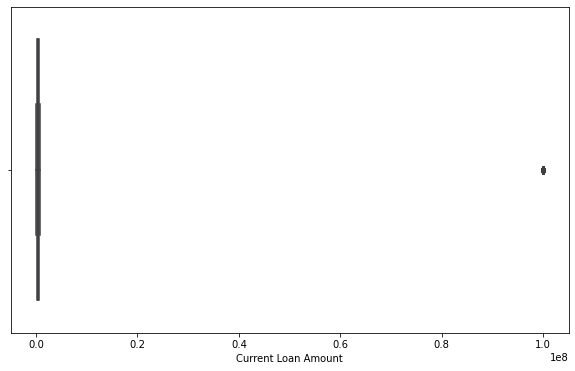

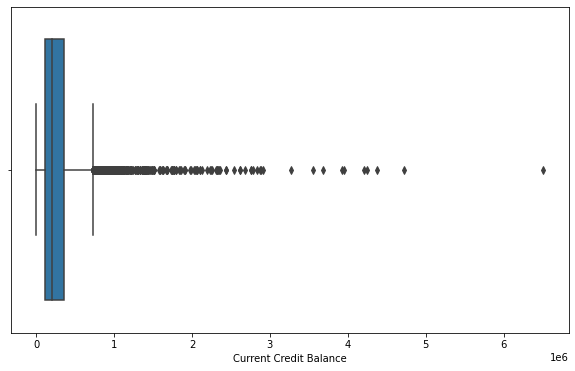

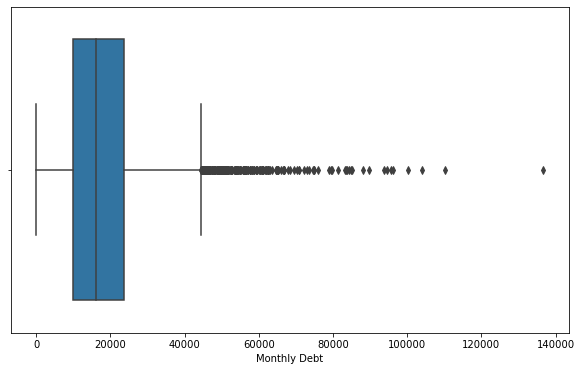

In [38]:
for col in num_col:
    plt.figure(figsize=(10,6))
    sns.boxplot(df_train[col])
    plt.show()

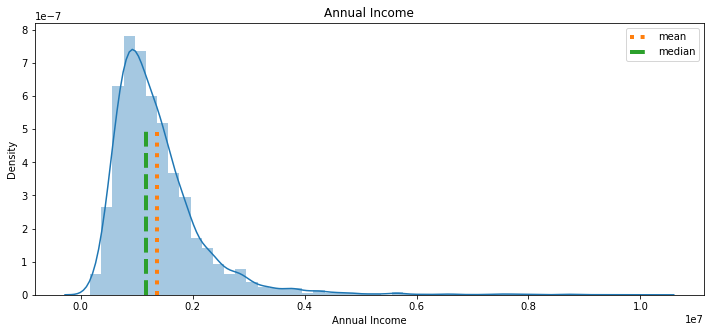

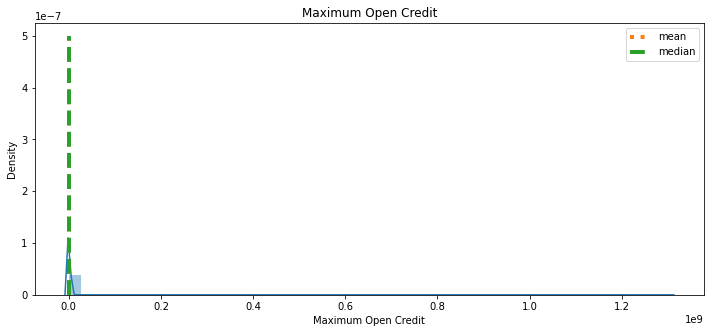

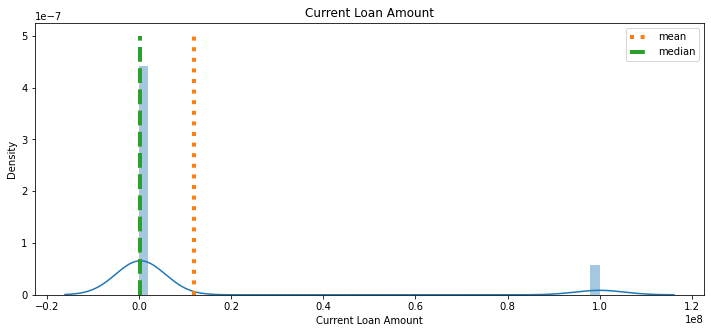

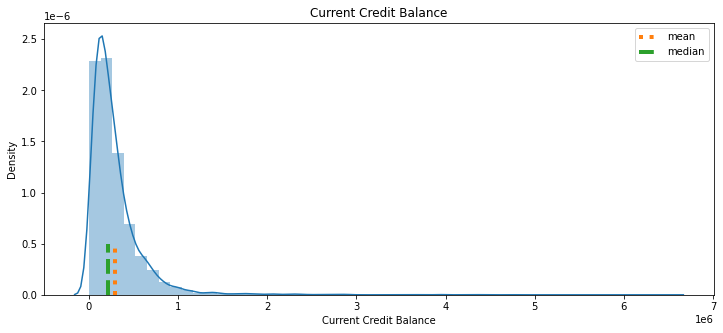

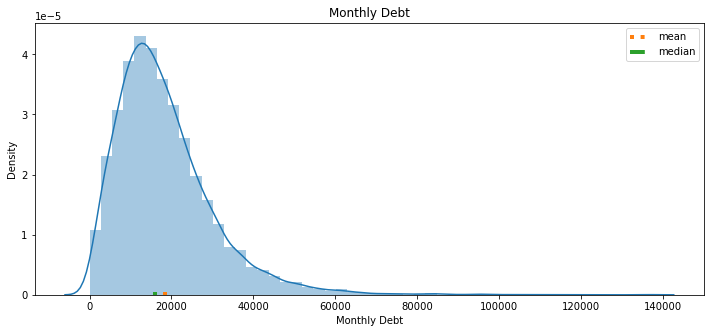

In [39]:
for col in num_col:
    pdf_plot(col, df_train)

In [40]:
print(df_train['Current Loan Amount'].mode())
df_train[df_train['Current Loan Amount'] > 10000000]['Current Loan Amount'].value_counts()

0    99999999.0
dtype: float64


99999999.0    870
Name: Current Loan Amount, dtype: int64

In [41]:
df_train[df_train['Maximum Open Credit'] > 200000000]['Maximum Open Credit']

44      3.800523e+08
617     1.304726e+09
2617    2.655129e+08
Name: Maximum Open Credit, dtype: float64

- Распределения Current Credit Balance и Monthly Debt выглядят нормально, отавим без изменений
- Current Loan Amount явно вызывает вопросы, так как имеет 870 значений равных 99999999.0(это же значение является модой), что подозрительно. Заменим с помощью KNNimputer(любое константное значение даст перекос в распределении). Кроме того создадим признак для того, чтобы возможная информация была сохранена.
- Размер максимального кредита больше 200 млн. считаем выбросом

**Поработаем с категориальными признаками**

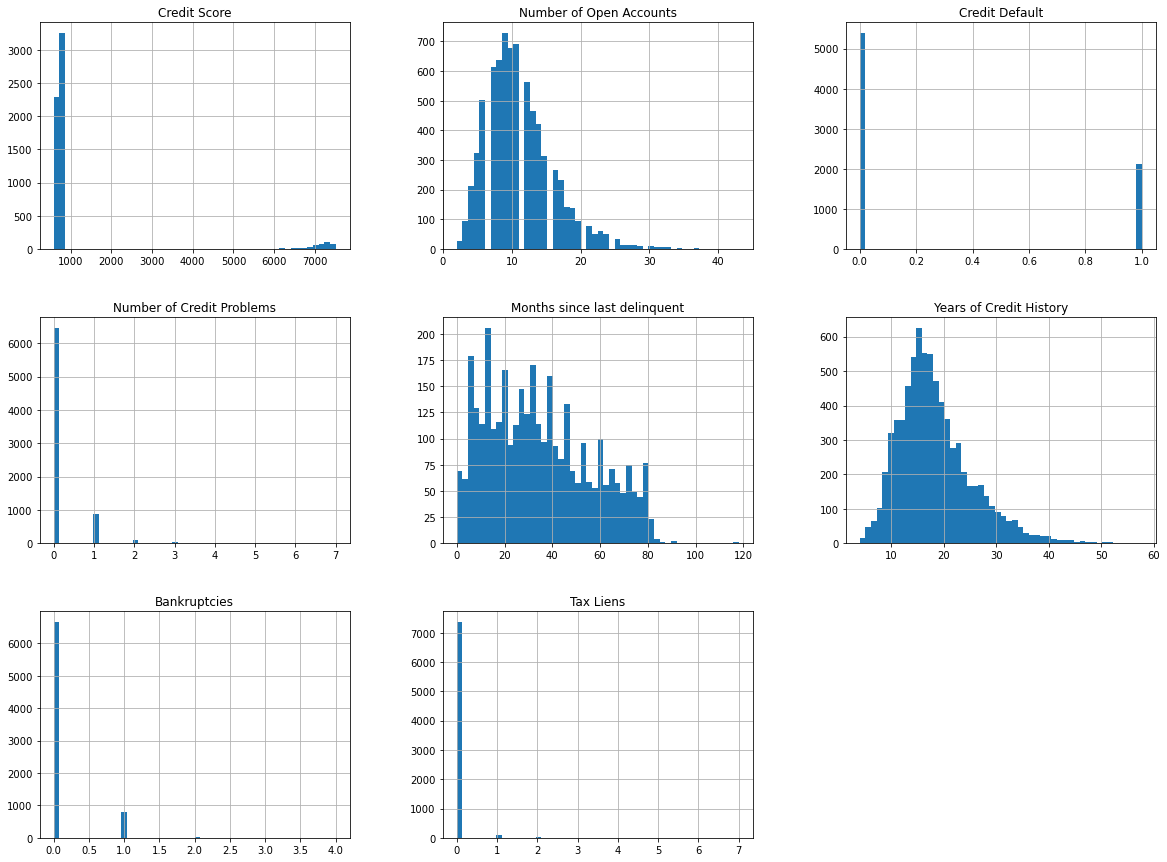

In [42]:
df_train[cat_col].hist(bins=50, figsize=(20,15));

**Выводы:**

Частично повторяемся, так как некоторые признаки уже оценивали на этапе анализа признаков с пропусками
- Bancruptcies, Tax Liens, Number of Credit Problems переведем в бинарные признаки
- Credit Score имеет выбросы

Current Loan Amount явно вызывает вопросы, так как имеет 870 значений равных 99999999.0, что подозрительно. Заменим с помощью KNNimputer(любое константное значение даст перекос в распределении). Кроме того создадим признак для того, чтобы возможная информация была сохранена.

Размер максимального кредита больше 200 млн. считаем выбросом

***

Оценим линейную зависимость 15 наиболее коррелированных с целевой переменной признаков

<Figure size 1152x720 with 0 Axes>

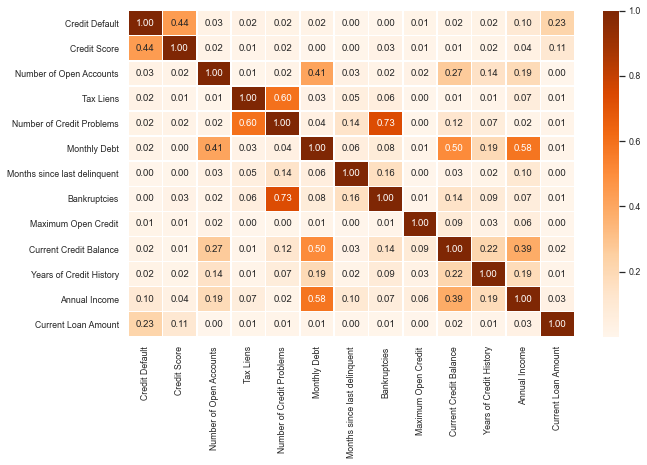

In [43]:
plt.figure(figsize=(16, 10))
k = 15
sns.set(font_scale=0.8)
cols = df_train.corr().nlargest(k, 'Credit Default')['Credit Default'].index
cm = df_train[cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(abs(cm), annot=True, fmt='.2f', linewidths=.5, cmap = 'Oranges')
plt.show()

Как и ожидалось, видим некоторую зависимость целевой переменной от Credit Score, Annual Income и Current Loan Amount

**Обработаем датафреймы**

In [44]:
y = df_train['Credit Default']
df_train = df_train.drop('Credit Default', axis=1)
res = dataframes_modification([df_train, df_test])
df_train, df_test = res[0], res[1]

### Обучение модели

Были получены следующие параметры модели:

In [45]:
cat_params = {'n_estimators': 250, 
              'boosting_type': 'Ordered', 
              'bootstrap_type': 'MVS', 
              'max_depth': 3, 
              'class_weights': [1, 2.5], 
              'silent': True,
              'bagging_temperature': 0.0,
              'l2_leaf_reg': 3.5,
              'early_stopping_rounds': 200,
              'learning_rate': 0.5242249207293501,
              'random_state': SEED 
}

Посмотрим результат модели на кроссвалидации

In [46]:
X = df_train
cat_model = cb.CatBoostClassifier(**cat_params)
cv = KFold(n_splits=5, random_state=SEED, shuffle=True)
score = cross_val_score(cat_model, X, y, cv=cv, scoring='f1')
f1_1 = np.mean(score)
print("Mean = {}".format(f1_1))

Mean = 0.5288045944798283


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, stratify=y, 
                                                    random_state=SEED)

In [48]:
cat_model.fit(X_train, y_train, plot=True, 
              use_best_model=True, 
              eval_set=(X_test, y_test))
y_train_pred = cat_model.predict(X_train)
y_test_pred = cat_model.predict(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0      0.846     0.733     0.786      3609
           1      0.492     0.659     0.564      1416

    accuracy                          0.712      5025
   macro avg      0.669     0.696     0.675      5025
weighted avg      0.746     0.712     0.723      5025

TEST

              precision    recall  f1-score   support

           0      0.848     0.717     0.777      1778
           1      0.482     0.673     0.562       697

    accuracy                          0.704      2475
   macro avg      0.665     0.695     0.669      2475
weighted avg      0.745     0.704     0.716      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1274  504
1                228  469


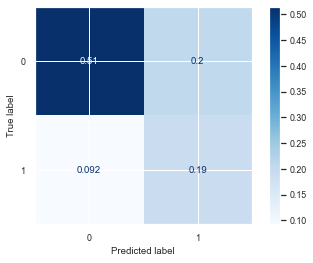

In [49]:
y_train_pred = cat_model.predict(X_train)
y_test_pred = cat_model.predict(X_test)
y_test_pred_probs = cat_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred, cat_model, X_test)

На тренировочной и тестовой выборке значение f1 для целевого класса практически не отличается, предполагаем, что переобученности модели нет

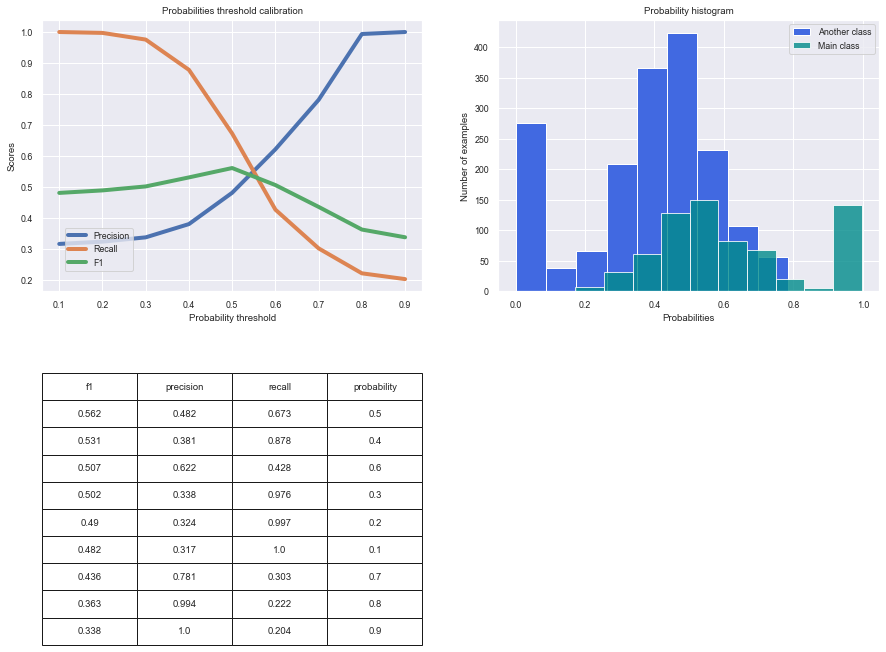

In [50]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

Видим, что оптимальное значение threshold'a у нас получилось как раз на 0.5, смещать не имеет смысла

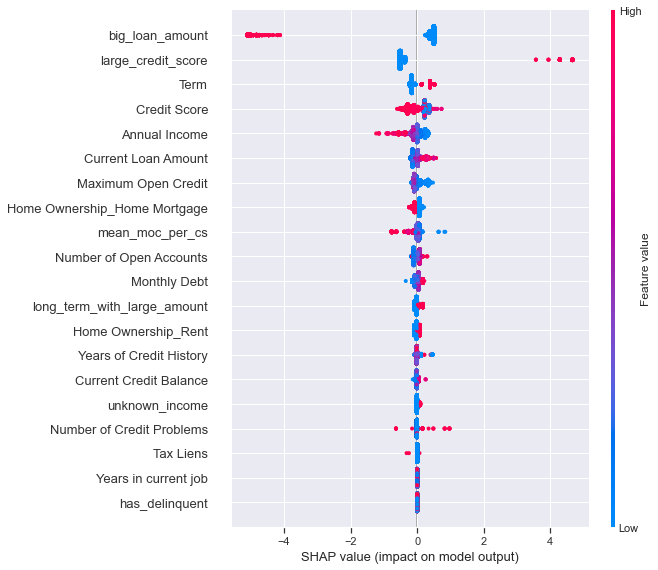

In [51]:
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_train, y_train) 
shap.summary_plot(shap_values, X_train)

Видим, что наиболее значимые признаки разделяют целевой класс значительно лучше, чем наименее значимые. Попробуем удалить часть столбцов

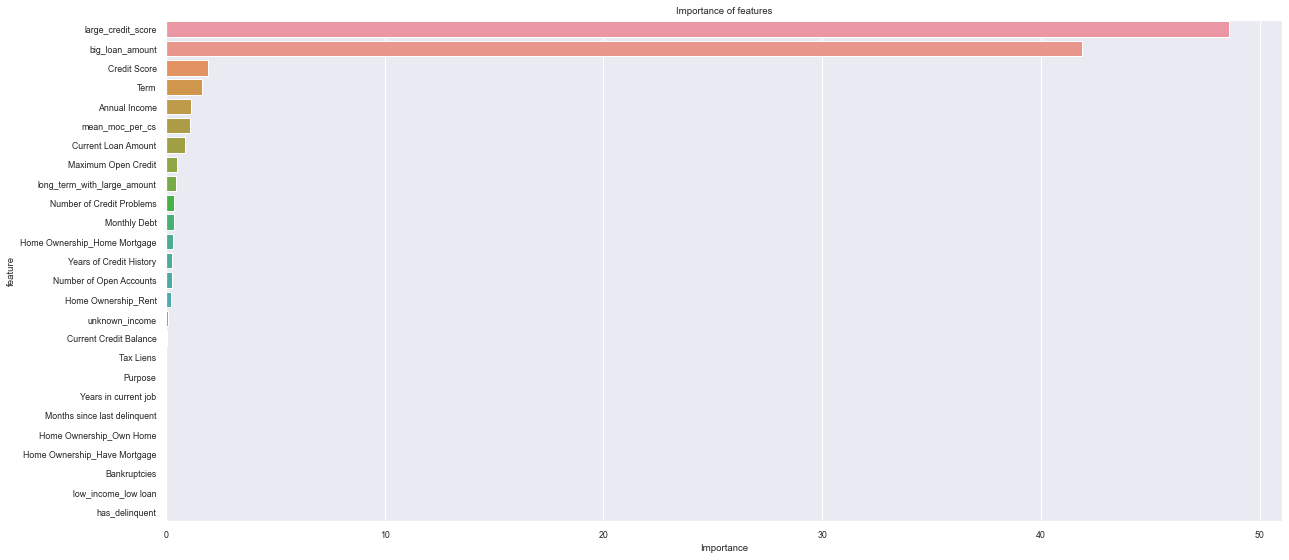

In [52]:
important_features_top = show_feature_importances(X.columns, cat_model.feature_importances_, get_top=16)

Попробуем использовать лучшие признаки по мнению catboost'a

In [53]:
X = df_train[important_features_top]
cat_model_1 = cb.CatBoostClassifier(**cat_params)
cv = KFold(n_splits=5, random_state=SEED, shuffle=True)
score = cross_val_score(cat_model, X, y, cv=cv, scoring='f1')
f1_2 = np.mean(score)
print("Mean = {}".format(f1_2))
print(f1_2-f1_1)

Mean = 0.5278363837144
-0.0009682107654283012


На кроссвалидации получили несколько меньшее значение. Посмотрим на train/test'e

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, stratify=y, 
                                                    random_state=SEED)

In [55]:
cat_model_1.fit(X_train, y_train, plot=True, 
              use_best_model=True, 
              eval_set=(X_test, y_test))
y_train_pred = cat_model_1.predict(X_train)
y_test_pred = cat_model_1.predict(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0      0.842     0.735     0.785      3609
           1      0.490     0.650     0.559      1416

    accuracy                          0.711      5025
   macro avg      0.666     0.692     0.672      5025
weighted avg      0.743     0.711     0.721      5025

TEST

              precision    recall  f1-score   support

           0      0.838     0.719     0.774      1778
           1      0.474     0.644     0.546       697

    accuracy                          0.698      2475
   macro avg      0.656     0.682     0.660      2475
weighted avg      0.735     0.698     0.710      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1279  499
1                248  449


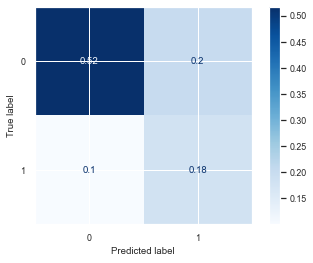

In [56]:
y_train_pred = cat_model_1.predict(X_train)
y_test_pred = cat_model_1.predict(X_test)
y_test_pred_probs = cat_model_1.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred, cat_model_1, X_test)

Упала метрика на тестовой выборке, кроме того, возрос уровень переобученности модели. Делаем вывод, что удаление "ненужных" признаков пользы не дает, оставляем как есть.

### Предскажем тестовую целевую переменную ###

In [57]:
predict_test = cat_model.predict(df_test)
preds_final = pd.DataFrame({'Id': np.arange(0,predict_test.shape[0]), 'Credit Default': predict_test})
preds_final.to_csv('AChernyshev_predictions.csv', index=False)
preds_final.head(10)

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,0
4,4,0
5,5,0
6,6,0
7,7,1
8,8,0
9,9,0


In [58]:
preds_final.shape

(2500, 2)

In [59]:
preds_final['Credit Default'].value_counts()

0    1552
1     948
Name: Credit Default, dtype: int64